<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [168]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import time
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import save_image

In [169]:
IN_MOMENTUM = 0.1

In [170]:
class ReflectionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ReflectionConv, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv(out)
        return out


In [171]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        conv_padding = int(np.floor(kernel_size / 2))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=conv_padding)
    def forward(self, x):
        return self.conv(x)

In [172]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(BasicBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.relu = nn.ReLU(inplace=True) # 1

        self.identity_block = nn.Sequential(
            ConvLayer(in_channels, out_channels // 4, kernel_size=1, stride=1),
            nn.InstanceNorm2d(out_channels // 4, momentum=IN_MOMENTUM),
            nn.ReLU(),
            ConvLayer(out_channels // 4, out_channels // 4, kernel_size, stride=stride),
            nn.InstanceNorm2d(out_channels // 4, momentum=IN_MOMENTUM),
            nn.ReLU(),
            ConvLayer(out_channels // 4, out_channels, kernel_size=1, stride=1),
            nn.InstanceNorm2d(out_channels, momentum=IN_MOMENTUM),
            nn.ReLU(),
        )
        self.shortcut = nn.Sequential(
            ConvLayer(in_channels, out_channels, 1, stride),
            nn.InstanceNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.identity_block(x)
        if self.in_channels == self.out_channels:
            residual = x
        else: 
            residual = self.shortcut(x)
        out += residual
        out = self.relu(out)

        return out


In [173]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor, mode):
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.instance = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.upsample(out)
        out = self.instance(out)
        out = self.relu(out)
        
        return out

In [174]:
class HRNet(nn.Module):
    def __init__(self):
        super(HRNet, self).__init__()

        self.pass1_1 = BasicBlock(3, 16, kernel_size=3, stride=1)
        self.pass1_2 = BasicBlock(16, 32, kernel_size=3, stride=1)
        self.pass1_3 = BasicBlock(32, 32, kernel_size=3, stride=1)
        self.pass1_4 = BasicBlock(64, 64, kernel_size=3, stride=1)
        self.pass1_5 = BasicBlock(192, 64, kernel_size=3, stride=1)
        self.pass1_6 = BasicBlock(64, 32, kernel_size=3, stride=1)
        self.pass1_7 = BasicBlock(32, 16, kernel_size=3, stride=1)
        self.pass1_8 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)
        self.pass2_1 = BasicBlock(32, 32, kernel_size=3, stride=1)
        self.pass2_2 = BasicBlock(64, 64, kernel_size=3, stride=1)
        
        self.downsample1_1 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.downsample1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.downsample1_3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.downsample1_4 = nn.Conv2d(32, 32, kernel_size=3, stride=4, padding=1)
        self.downsample1_5 = nn.Conv2d(64, 64, kernel_size=3, stride=4, padding=1)
        self.downsample2_1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.downsample2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)

        self.upsample1_1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample1_2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2_1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.upsample2_2 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        map1 = self.pass1_1(x)
        map2 = self.pass1_2(map1)
        map3 = self.downsample1_1(map1)
        map4 = torch.cat((self.pass1_3(map2), self.upsample1_1(map3)), 1)
        map5 = torch.cat((self.downsample1_2(map2), self.pass2_1(map3)), 1)
        map6 = torch.cat((self.downsample1_4(map2), self.downsample2_1(map3)), 1)
        map7 = torch.cat((self.pass1_4(map4), self.upsample1_2(map5), self.upsample2_1(map6)), 1)
        out = self.pass1_5(map7)
        out = self.pass1_6(out)
        out = self.pass1_7(out)
        out = self.pass1_8(out)

        return out


In [175]:
def load_image(img_path, img_size=None):
    image = Image.open(img_path)
    if img_size is not None:
        image = image.resize((img_size, img_size))  # change image size to (3, img_size, img_size)
    
    transform = transforms.Compose([
                        # convert the (H x W x C) PIL image in the range(0, 255) into (C x H x W) tensor in the range(0.0, 1.0) 
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),   # this is from ImageNet dataset
                        ])   

    # change image's size to (b, 3, h, w)
    image = transform(image)[:3, :, :].unsqueeze(0)

    return image

In [176]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)    # change size to (channel, height, width)
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))   # change into unnormalized image
    image = image.clip(0, 1)    # in the previous steps, we change PIL image(0, 255) into tensor(0.0, 1.0), so convert it

    return image

In [177]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',   # default style layer
                  '5': 'conv2_1',   # default style layer
                  '10': 'conv3_1',  # default style layer
                  '19': 'conv4_1',  # default style layer
                  '21': 'conv4_2',  # default content layer
                  '28': 'conv5_1'}  # default style layer
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)    #  layer(x) is the feature map through the layer when the input is x
        if name in layers:
            features[layers[name]] = x
    
    return features

In [178]:
def get_grim_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b * c, h * w)
    gram_matrix = torch.mm(tensor, tensor.t())
    return gram_matrix

In [179]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [180]:
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
print(VGG)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [181]:
style_net = HRNet()
style_net.to(device)
print(style_net)

HRNet(
  (pass1_1): BasicBlock(
    (relu): ReLU(inplace=True)
    (identity_block): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): ConvLayer(
        (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU()
      (6): ConvLayer(
        (conv): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (7): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (8): ReLU()
    )
    (shortcut): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (pass1_2): BasicBlock(
    

In [182]:
content_image = load_image("redbull f1 car46.jpg", img_size=256) 
content_image = content_image.to(device)

style_image = load_image("CASPAR DAVID FRIEDRICH paintings68.jpg")  
style_image = style_image.to(device)

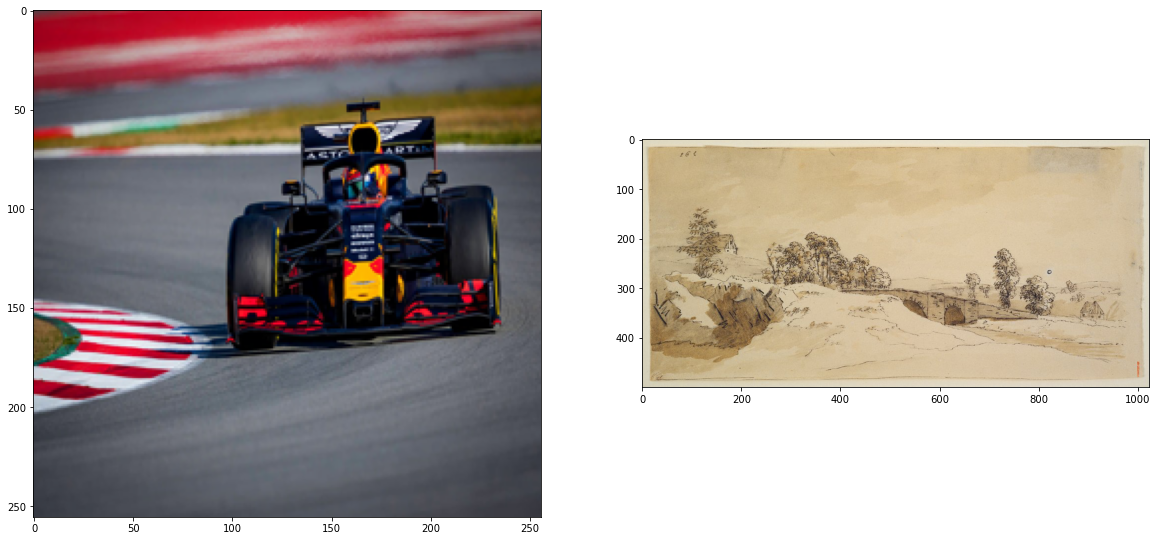

In [183]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))
plt.show()

In [184]:
content_features = get_features(content_image, VGG)
style_features   = get_features(style_image, VGG)

style_gram_matrixs = {layer: get_grim_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to(device)

In [185]:
# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = 200
style_weight = 1

optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_image

Step - 0 => Total Loss - 4566.73583984375, Content Loss - 16.63570785522461, Style Loss - 1239.59423828125 


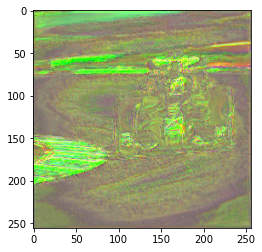

Step - 100 => Total Loss - 927.760498046875, Content Loss - 0.9100663661956787, Style Loss - 745.7472534179688 


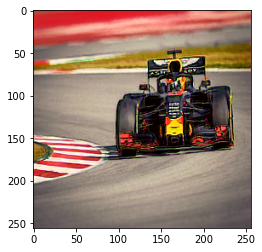

Step - 200 => Total Loss - 759.3983154296875, Content Loss - 0.894899308681488, Style Loss - 580.41845703125 


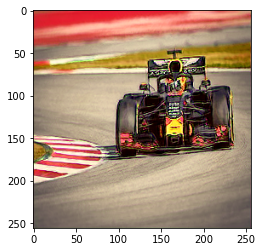

Step - 300 => Total Loss - 650.3296508789062, Content Loss - 0.9130539894104004, Style Loss - 467.7188415527344 


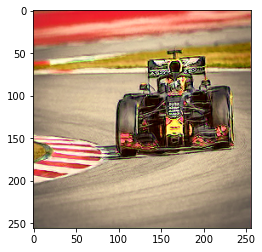

Step - 400 => Total Loss - 583.676513671875, Content Loss - 0.782906174659729, Style Loss - 427.09527587890625 


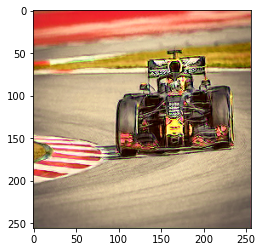

Step - 500 => Total Loss - 541.730712890625, Content Loss - 0.7222493290901184, Style Loss - 397.28082275390625 


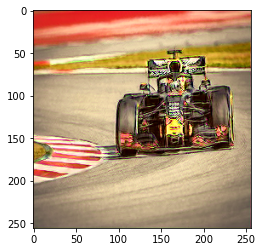

Step - 600 => Total Loss - 518.733154296875, Content Loss - 0.6893812417984009, Style Loss - 380.85693359375 


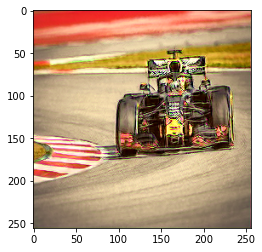

Step - 700 => Total Loss - 493.61785888671875, Content Loss - 0.6213648319244385, Style Loss - 369.34490966796875 


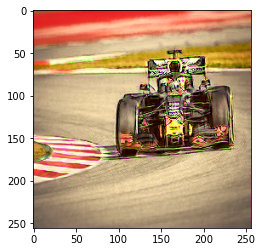

Step - 800 => Total Loss - 486.84649658203125, Content Loss - 0.6410263776779175, Style Loss - 358.6412048339844 


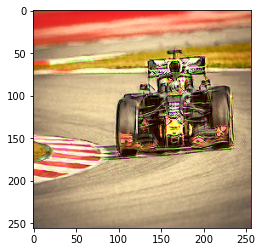

Step - 900 => Total Loss - 462.244140625, Content Loss - 0.5874096155166626, Style Loss - 344.76220703125 


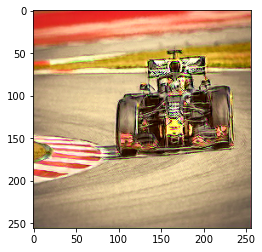

Step - 1000 => Total Loss - 467.5128173828125, Content Loss - 0.6264216899871826, Style Loss - 342.2284851074219 


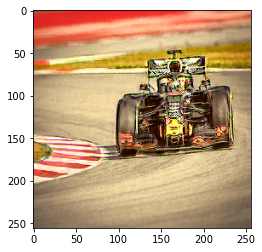

In [186]:
for epoch in range(0, steps+1):
    
    scheduler.step()

    target = style_net(content_image).to(device)
    target.requires_grad_(True)


    target_features = get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and adding them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)
    

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss)

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Step - {} => Total Loss - {}, Content Loss - {}, Style Loss - {} ".format(epoch,total_loss.item(), content_loss.item(), style_loss.item()))
        plt.imshow(im_convert(target))
        plt.show()

    output_image = target

In [187]:
img = im_convert(output_image)

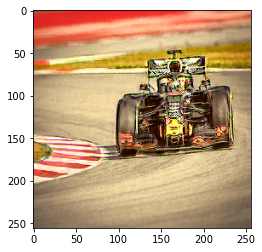

In [188]:
plt.imshow(img)
plt.show()

In [189]:
fig = plt.figure(frameon=False)
fig.set_size_inches(3.556, 3.556)

<Figure size 256.032x256.032 with 0 Axes>

In [190]:
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

In [191]:
ax.imshow(img, aspect='auto')
fig.savefig('redbull f1 car46-CASPAR DAVID FRIEDRICH paintings68.png')